In [21]:
"""
Phase 5: Endothelial-Focused Analysis
======================================
Following validation results showing robust endothelial elevation in MDD (d=0.52, p=0.001)

Goals:
1. Identify genes correlated with endothelial scores
2. Pathway enrichment analysis
3. WGCNA module correlations with endothelial signature
4. Cross-dataset consistency check
"""

import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [22]:
# ==========================================
# CONFIGURATION
# ==========================================
PHASE3_DIR = "./output/Phase_3"
PHASE4_DIR = "./output/Phase_4"
PHASE5_DIR = "./output/Phase_5"
DATA_DIR = "./data"

os.makedirs(PHASE5_DIR, exist_ok=True)

# Endothelial markers (from Phase 3)
ENDOTHELIAL_MARKERS = ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

In [23]:
# ==========================================
# LOAD DATA
# ==========================================
print("="*60)
print("PHASE 5: ENDOTHELIAL-FOCUSED ANALYSIS")
print("="*60)

# Load original dataset (GSE54564)
print("\nLoading original dataset (GSE54564)...")
matrix_path = os.path.join(DATA_DIR, "GSE54564_series_matrix.txt")
annotation_path = os.path.join(DATA_DIR, "NCBI_Depression.bgx")

matrix_data = pd.read_csv(matrix_path, sep="\t", comment="!", index_col=0)

PHASE 5: ENDOTHELIAL-FOCUSED ANALYSIS

Loading original dataset (GSE54564)...


In [24]:
# Get labels
labels = []
with open(matrix_path, 'r') as f:
    for line in f:
        if "disease state" in line.lower():
            labels = line.strip().split("\t")[1:]
            break

y_orig = (pd.Series(labels, index=matrix_data.columns)
     .str.replace('"', '').str.replace('disease state:', "").str.strip()
     .map({"MDD case": 1, "Control": 0})).values

In [25]:

# Load annotations
with open(annotation_path, 'r') as f:
    lines = f.readlines()
start = next(i+1 for i, line in enumerate(lines) if line.strip() == "[Probes]")
bgx = pd.read_csv(annotation_path, sep="\t", skiprows=start, engine="python")

probe_col = 'Probe_Id' if 'Probe_Id' in bgx.columns else 'Name'
probe_to_gene = dict(zip(bgx[probe_col], bgx['Symbol']))

In [26]:
# Map probes to genes
gene_names_orig = []
valid_probes = []
for probe in matrix_data.index:
    if probe in probe_to_gene and pd.notna(probe_to_gene[probe]):
        gene = str(probe_to_gene[probe]).strip()
        if gene:
            gene_names_orig.append(gene)
            valid_probes.append(probe)

X_orig = matrix_data.loc[valid_probes].T.values
if np.max(X_orig) > 100:
    X_orig = np.log2(X_orig + 1)
X_orig = stats.zscore(X_orig, axis=0)
X_orig = np.nan_to_num(X_orig, nan=0.0)

print(f"  Original: {X_orig.shape[0]} samples x {X_orig.shape[1]} genes")

  Original: 42 samples x 36157 genes


In [27]:
# Load validation dataset (GSE98793)
print("\nLoading validation dataset (GSE98793)...")
expr_val = pd.read_csv(f"{DATA_DIR}/GSE98793_prepared_expression.csv", index_col=0)
meta_val = pd.read_csv(f"{DATA_DIR}/GSE98793_metadata.csv", index_col=0)
y_val = (meta_val['Status'] == 'MDD').astype(int).values

# Z-score normalize validation data
X_val = stats.zscore(expr_val.values.T, axis=0)
X_val = np.nan_to_num(X_val, nan=0.0)
gene_names_val = expr_val.index.tolist()

print(f"  Validation: {X_val.shape[0]} samples x {X_val.shape[1]} genes")


Loading validation dataset (GSE98793)...
  Validation: 192 samples x 23520 genes


In [28]:
# ==========================================
# COMPUTE ENDOTHELIAL SCORES
# ==========================================
print("\n" + "="*60)
print("COMPUTING ENDOTHELIAL SCORES")
print("="*60)

def compute_cell_score(X, gene_names, markers):
    """Compute cell-type score as mean of marker genes"""
    gene_to_idx = {g.upper(): i for i, g in enumerate(gene_names)}
    found = [m for m in markers if m.upper() in gene_to_idx]
    if len(found) < 3:
        return None, found
    idx = [gene_to_idx[m.upper()] for m in found]
    scores = np.mean(X[:, idx], axis=1)
    return scores, found

# Original dataset
endo_orig, markers_found_orig = compute_cell_score(X_orig, gene_names_orig, ENDOTHELIAL_MARKERS)
print(f"\nOriginal dataset:")
print(f"  Markers found: {len(markers_found_orig)}/{len(ENDOTHELIAL_MARKERS)}")
print(f"  Markers: {markers_found_orig}")

# Validation dataset
endo_val, markers_found_val = compute_cell_score(X_val, gene_names_val, ENDOTHELIAL_MARKERS)
print(f"\nValidation dataset:")
print(f"  Markers found: {len(markers_found_val)}/{len(ENDOTHELIAL_MARKERS)}")
print(f"  Markers: {markers_found_val}")


COMPUTING ENDOTHELIAL SCORES



Original dataset:
  Markers found: 5/5
  Markers: ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

Validation dataset:
  Markers found: 5/5
  Markers: ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']


In [30]:
# ==========================================
# STEP 1: GENES CORRELATED WITH ENDOTHELIAL SCORE
# ==========================================
print("\n" + "="*60)
print("STEP 1: IDENTIFYING ENDOTHELIAL-CORRELATED GENES")
print("="*60)

def get_correlated_genes(X, gene_names, endo_scores, dataset_name):
    """Find genes significantly correlated with endothelial scores"""
    results = []
    for i, gene in enumerate(gene_names):
        r, p = spearmanr(X[:, i], endo_scores)
        results.append({
            'gene': gene,
            'correlation': r,
            'p_value': p
        })
    
    df = pd.DataFrame(results)
    df['p_adjusted'] = stats.false_discovery_control(df['p_value'], method='bh')
    df = df.sort_values('p_value')
    
    sig_pos = df[(df['p_adjusted'] < 0.05) & (df['correlation'] > 0)]
    sig_neg = df[(df['p_adjusted'] < 0.05) & (df['correlation'] < 0)]
    
    print(f"\n{dataset_name}:")
    print(f"  Significant genes (FDR < 0.05): {len(df[df['p_adjusted'] < 0.05])}")
    print(f"    Positively correlated: {len(sig_pos)}")
    print(f"    Negatively correlated: {len(sig_neg)}")
    
    return df

# Get correlated genes from both datasets
corr_orig = get_correlated_genes(X_orig, gene_names_orig, endo_orig, "Original (GSE54564)")
corr_val = get_correlated_genes(X_val, gene_names_val, endo_val, "Validation (GSE98793)")

# Find consensus genes (significant in both datasets, same direction)
print("\n" + "-"*40)
print("CONSENSUS GENES (significant in both datasets)")
print("-"*40)

sig_orig = set(corr_orig[corr_orig['p_adjusted'] < 0.05]['gene'].str.upper())
sig_val = set(corr_val[corr_val['p_adjusted'] < 0.05]['gene'].str.upper())
consensus_genes = sig_orig.intersection(sig_val)

# Check direction consistency
consensus_pos = []
consensus_neg = []

for gene in consensus_genes:
    r_orig = corr_orig[corr_orig['gene'].str.upper() == gene]['correlation'].values
    r_val = corr_val[corr_val['gene'].str.upper() == gene]['correlation'].values
    
    if len(r_orig) > 0 and len(r_val) > 0:
        if r_orig[0] > 0 and r_val[0] > 0:
            consensus_pos.append(gene)
        elif r_orig[0] < 0 and r_val[0] < 0:
            consensus_neg.append(gene)

print(f"\nConsensus positively correlated: {len(consensus_pos)} genes")
print(f"Consensus negatively correlated: {len(consensus_neg)} genes")


# Save gene lists
with open(f"{PHASE5_DIR}/endothelial_correlated_positive.txt", 'w') as f:
    f.write('\n'.join(sorted(consensus_pos)))
    
with open(f"{PHASE5_DIR}/endothelial_correlated_negative.txt", 'w') as f:
    f.write('\n'.join(sorted(consensus_neg)))

print(f"\nSaved gene lists to {PHASE5_DIR}/")


STEP 1: IDENTIFYING ENDOTHELIAL-CORRELATED GENES

Original (GSE54564):
  Significant genes (FDR < 0.05): 784
    Positively correlated: 401
    Negatively correlated: 383

Validation (GSE98793):
  Significant genes (FDR < 0.05): 13540
    Positively correlated: 8873
    Negatively correlated: 4667

----------------------------------------
CONSENSUS GENES (significant in both datasets)
----------------------------------------

Consensus positively correlated: 161 genes
Consensus negatively correlated: 112 genes

Saved gene lists to ./output/Phase_5/


In [31]:
# ==========================================
# STEP 2: PATHWAY ENRICHMENT (Enrichr API)
# ==========================================
print("\n" + "="*60)
print("STEP 2: PATHWAY ENRICHMENT ANALYSIS")
print("="*60)

def run_enrichr(gene_list, description="gene_list"):
    """Submit gene list to Enrichr and retrieve results"""
    
    ENRICHR_URL = "https://maayanlab.cloud/Enrichr"
    
    # Add genes
    payload = {
        'list': (None, '\n'.join(gene_list)),
        'description': (None, description)
    }
    
    try:
        response = requests.post(f"{ENRICHR_URL}/addList", files=payload)
        if not response.ok:
            print(f"  Error adding gene list: {response.status_code}")
            return None
        
        data = response.json()
        user_list_id = data['userListId']
        
        # Query databases
        databases = [
            'GO_Biological_Process_2023',
            'GO_Molecular_Function_2023', 
            'KEGG_2021_Human',
            'Reactome_2022',
            'WikiPathway_2023_Human'
        ]
        
        all_results = {}
        
        for db in databases:
            time.sleep(0.5)  # Rate limiting
            response = requests.get(f"{ENRICHR_URL}/enrich?userListId={user_list_id}&backgroundType={db}")
            
            if response.ok:
                results = response.json()
                if db in results:
                    all_results[db] = results[db]
        
        return all_results
    
    except Exception as e:
        print(f"  Enrichr API error: {e}")
        return None

def parse_enrichr_results(results, top_n=10):
    """Parse Enrichr results into DataFrame"""
    parsed = []
    
    for db, terms in results.items():
        for term_data in terms[:top_n]:
            parsed.append({
                'database': db,
                'term': term_data[1],
                'p_value': term_data[2],
                'odds_ratio': term_data[3],
                'combined_score': term_data[4],
                'genes': ';'.join(term_data[5]),
                'adj_p_value': term_data[6]
            })
    
    return pd.DataFrame(parsed)

# Run enrichment on positively correlated genes (co-expressed with endothelial)
if len(consensus_pos) >= 10:
    print(f"\nRunning Enrichr on {len(consensus_pos)} positively correlated genes...")
    enrichr_pos = run_enrichr(list(consensus_pos), "endothelial_positive")
    
    if enrichr_pos:
        enrichr_pos_df = parse_enrichr_results(enrichr_pos, top_n=15)
        enrichr_pos_df.to_csv(f"{PHASE5_DIR}/enrichr_positive_correlated.csv", index=False)
        
        print("\nTop pathways (positively correlated with endothelial):")
        print("-"*60)
        top_pathways = enrichr_pos_df.nsmallest(10, 'adj_p_value')
        for _, row in top_pathways.iterrows():
            print(f"  {row['term'][:50]}")
            print(f"    p={row['adj_p_value']:.2e}, score={row['combined_score']:.1f}")
else:
    print(f"\nToo few consensus positive genes ({len(consensus_pos)}) for enrichment")
    enrichr_pos_df = None


# Run enrichment on negatively correlated genes
if len(consensus_neg) >= 10:
    print(f"\nRunning Enrichr on {len(consensus_neg)} negatively correlated genes...")
    enrichr_neg = run_enrichr(list(consensus_neg), "endothelial_negative")
    
    if enrichr_neg:
        enrichr_neg_df = parse_enrichr_results(enrichr_neg, top_n=15)
        enrichr_neg_df.to_csv(f"{PHASE5_DIR}/enrichr_negative_correlated.csv", index=False)
        
        print("\nTop pathways (negatively correlated with endothelial):")
        print("-"*60)
        top_pathways = enrichr_neg_df.nsmallest(10, 'adj_p_value')
        for _, row in top_pathways.iterrows():
            print(f"  {row['term'][:50]}")
            print(f"    p={row['adj_p_value']:.2e}, score={row['combined_score']:.1f}")
else:
    print(f"\nToo few consensus negative genes ({len(consensus_neg)}) for enrichment")
    enrichr_neg_df = None



STEP 2: PATHWAY ENRICHMENT ANALYSIS

Running Enrichr on 161 positively correlated genes...

Top pathways (positively correlated with endothelial):
------------------------------------------------------------
  Interferon Alpha/Beta Signaling R-HSA-909733
    p=6.78e-05, score=258.2
  Defective CHST3 Causes SEDCJD R-HSA-3595172
    p=8.17e-05, score=1908.0
  Disease R-HSA-1643685
    p=5.16e-04, score=35.3
  Diseases Associated With Glycosaminoglycan Metabol
    p=2.10e-03, score=199.6
  Chondroitin Sulfate Biosynthesis R-HSA-2022870
    p=2.10e-03, score=345.3
  Defective CHST14 Causes EDS, Musculocontractural T
    p=2.35e-03, score=790.0
  Defective CHSY1 Causes TPBS R-HSA-3595177
    p=2.35e-03, score=790.0
  Interferon Signaling R-HSA-913531
    p=2.66e-03, score=62.3
  Human papillomavirus infection
    p=3.07e-03, score=54.4
  Leukocyte transendothelial migration
    p=3.71e-03, score=85.2

Running Enrichr on 112 negatively correlated genes...

Top pathways (negatively correlate

In [32]:
# ==========================================
# STEP 3: WGCNA MODULE CORRELATIONS
# ==========================================
print("\n" + "="*60)
print("STEP 3: WGCNA MODULE - ENDOTHELIAL CORRELATIONS")
print("="*60)

# Load module gene lists from Phase 3
module_files = [f for f in os.listdir(PHASE3_DIR) if f.startswith('M') and f.endswith('_genes.txt')]

if module_files:
    print(f"\nFound {len(module_files)} modules from Phase 3")
    
    modules = {}
    for mf in sorted(module_files):
        mod_name = mf.replace('_genes.txt', '')
        with open(os.path.join(PHASE3_DIR, mf), 'r') as f:
            genes = [g.strip() for g in f.readlines() if g.strip()]
        modules[mod_name] = genes
        print(f"  {mod_name}: {len(genes)} genes")
    
    # Compute module eigengenes in original dataset
    print("\nComputing module-endothelial correlations...")
    
    gene_to_idx_orig = {g.upper(): i for i, g in enumerate(gene_names_orig)}
    
    module_endo_corr = []
    
    for mod_name, mod_genes in modules.items():
        # Get module gene indices
        mod_idx = [gene_to_idx_orig[g.upper()] for g in mod_genes if g.upper() in gene_to_idx_orig]
        
        if len(mod_idx) < 5:
            continue
        
        # Compute eigengene (first PC)
        from sklearn.decomposition import PCA
        mod_expr = X_orig[:, mod_idx]
        pca = PCA(n_components=1)
        eigengene = pca.fit_transform(mod_expr - mod_expr.mean(axis=0)).flatten()
        
        # Correlation with endothelial score
        r, p = spearmanr(eigengene, endo_orig)
        
        # Also check correlation with diagnosis
        r_diag, p_diag = stats.pointbiserialr(y_orig, eigengene)
        
        module_endo_corr.append({
            'module': mod_name,
            'n_genes': len(mod_idx),
            'endo_correlation': r,
            'endo_p_value': p,
            'diagnosis_correlation': r_diag,
            'diagnosis_p_value': p_diag
        })
        
        sig_endo = '*' if p < 0.05 else ''
        sig_diag = '*' if p_diag < 0.05 else ''
        print(f"  {mod_name}: endo r={r:.3f}{sig_endo}, diag r={r_diag:.3f}{sig_diag}")
    
    module_endo_df = pd.DataFrame(module_endo_corr)
    module_endo_df.to_csv(f"{PHASE5_DIR}/module_endothelial_correlations.csv", index=False)
    
    # Identify modules correlated with BOTH endothelial and diagnosis
    print("\n" + "-"*40)
    print("MODULES ASSOCIATED WITH BOTH ENDOTHELIAL & DIAGNOSIS")
    print("-"*40)
    
    dual_sig = module_endo_df[
        (module_endo_df['endo_p_value'] < 0.1) & 
        (module_endo_df['diagnosis_p_value'] < 0.1)
    ]
    
    if len(dual_sig) > 0:
        for _, row in dual_sig.iterrows():
            print(f"\n  {row['module']} ({row['n_genes']} genes):")
            print(f"    Endothelial: r={row['endo_correlation']:.3f}, p={row['endo_p_value']:.4f}")
            print(f"    Diagnosis:   r={row['diagnosis_correlation']:.3f}, p={row['diagnosis_p_value']:.4f}")
            
            # Get hub genes for this module
            hub_file = os.path.join(PHASE3_DIR, 'all_hub_genes.txt')
            if os.path.exists(hub_file):
                with open(hub_file, 'r') as f:
                    all_hubs = [g.strip() for g in f.readlines()]
                mod_hubs = [h for h in all_hubs if h in modules[row['module']]]
                if mod_hubs:
                    print(f"    Hub genes: {', '.join(mod_hubs[:5])}")
    else:
        print("  No modules significantly associated with both")

else:
    print("No module files found in Phase 3 output")
    module_endo_df = None






STEP 3: WGCNA MODULE - ENDOTHELIAL CORRELATIONS

Found 8 modules from Phase 3
  M1: 96 genes
  M2: 39 genes
  M3: 88 genes
  M4: 101 genes
  M5: 43 genes
  M6: 120 genes
  M7: 104 genes
  M8: 3409 genes

Computing module-endothelial correlations...
  M1: endo r=-0.291, diag r=-0.101
  M2: endo r=0.270, diag r=0.188
  M3: endo r=0.069, diag r=-0.220
  M4: endo r=-0.227, diag r=-0.203
  M5: endo r=-0.018, diag r=0.223
  M6: endo r=-0.018, diag r=-0.009
  M7: endo r=-0.284, diag r=-0.179
  M8: endo r=0.524*, diag r=0.290

----------------------------------------
MODULES ASSOCIATED WITH BOTH ENDOTHELIAL & DIAGNOSIS
----------------------------------------

  M8 (3409 genes):
    Endothelial: r=0.524, p=0.0004
    Diagnosis:   r=0.290, p=0.0628
    Hub genes: VCX3A, GABRE, GLRB, SERPINI1, MDH1



GENERATING FIGURES

Saved: ./output/Phase_5/Figure5_Endothelial_Analysis.png


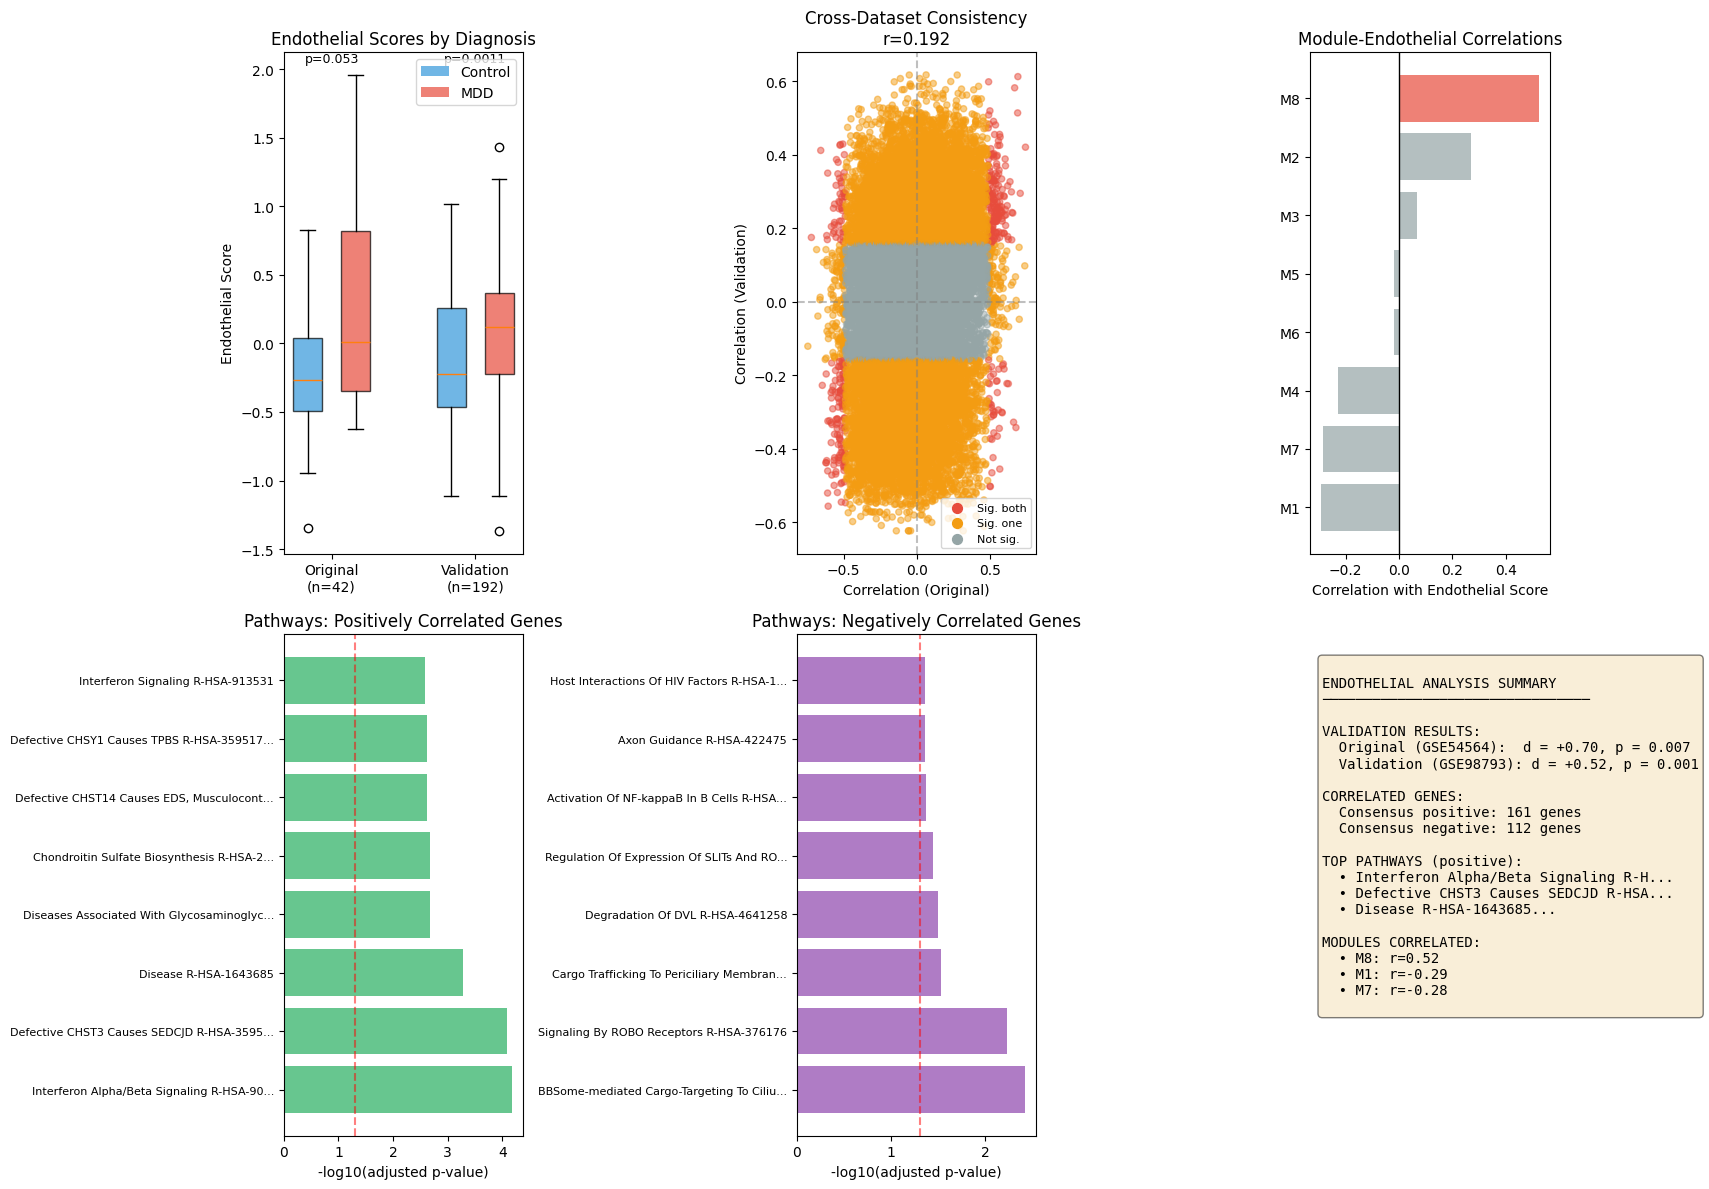

In [33]:
# ==========================================
# STEP 4: VISUALIZATION
# ==========================================
print("\n" + "="*60)
print("GENERATING FIGURES")
print("="*60)

fig = plt.figure(figsize=(16, 12))

# Panel A: Endothelial scores by diagnosis (both datasets)
ax1 = fig.add_subplot(2, 3, 1)

data_box = [
    endo_orig[y_orig == 0], endo_orig[y_orig == 1],
    endo_val[y_val == 0], endo_val[y_val == 1]
]
positions = [1, 2, 4, 5]
colors_box = ['#3498db', '#e74c3c', '#3498db', '#e74c3c']

bp = ax1.boxplot(data_box, positions=positions, widths=0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xticks([1.5, 4.5])
ax1.set_xticklabels(['Original\n(n=42)', 'Validation\n(n=192)'])
ax1.set_ylabel('Endothelial Score')
ax1.set_title('Endothelial Scores by Diagnosis')
ax1.legend([plt.Rectangle((0,0),1,1, fc='#3498db', alpha=0.7),
            plt.Rectangle((0,0),1,1, fc='#e74c3c', alpha=0.7)],
           ['Control', 'MDD'], loc='upper right')

# Add significance annotations
from scipy.stats import mannwhitneyu
_, p_orig = mannwhitneyu(endo_orig[y_orig==1], endo_orig[y_orig==0])
_, p_val = mannwhitneyu(endo_val[y_val==1], endo_val[y_val==0])

y_max = max(max(d) for d in data_box)
ax1.annotate(f'p={p_orig:.3f}', xy=(1.5, y_max*1.05), ha='center', fontsize=9)
ax1.annotate(f'p={p_val:.4f}', xy=(4.5, y_max*1.05), ha='center', fontsize=9)

# Panel B: Correlation consistency scatter
ax2 = fig.add_subplot(2, 3, 2)

# Merge correlations by gene
corr_orig_upper = corr_orig.copy()
corr_orig_upper['gene_upper'] = corr_orig_upper['gene'].str.upper()
corr_val_upper = corr_val.copy()
corr_val_upper['gene_upper'] = corr_val_upper['gene'].str.upper()

merged_corr = corr_orig_upper.merge(
    corr_val_upper[['gene_upper', 'correlation', 'p_adjusted']], 
    on='gene_upper', 
    suffixes=('_orig', '_val')
)

# Color by significance
colors_scatter = []
for _, row in merged_corr.iterrows():
    if row['p_adjusted_orig'] < 0.05 and row['p_adjusted_val'] < 0.05:
        colors_scatter.append('#e74c3c')  # Significant in both
    elif row['p_adjusted_orig'] < 0.05 or row['p_adjusted_val'] < 0.05:
        colors_scatter.append('#f39c12')  # Significant in one
    else:
        colors_scatter.append('#95a5a6')  # Not significant

ax2.scatter(merged_corr['correlation_orig'], merged_corr['correlation_val'], 
           c=colors_scatter, alpha=0.5, s=20)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Correlation of correlations
r_corr, _ = pearsonr(merged_corr['correlation_orig'], merged_corr['correlation_val'])
ax2.set_xlabel('Correlation (Original)')
ax2.set_ylabel('Correlation (Validation)')
ax2.set_title(f'Cross-Dataset Consistency\nr={r_corr:.3f}')

ax2.legend([plt.scatter([],[], c='#e74c3c', s=50),
            plt.scatter([],[], c='#f39c12', s=50),
            plt.scatter([],[], c='#95a5a6', s=50)],
           ['Sig. both', 'Sig. one', 'Not sig.'],
           loc='lower right', fontsize=8)

# Panel C: Module-endothelial correlations
ax3 = fig.add_subplot(2, 3, 3)

if module_endo_df is not None and len(module_endo_df) > 0:
    mod_sorted = module_endo_df.sort_values('endo_correlation')
    colors_mod = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in mod_sorted['endo_p_value']]
    
    ax3.barh(range(len(mod_sorted)), mod_sorted['endo_correlation'], color=colors_mod, alpha=0.7)
    ax3.set_yticks(range(len(mod_sorted)))
    ax3.set_yticklabels(mod_sorted['module'])
    ax3.axvline(0, color='black', linewidth=1)
    ax3.set_xlabel('Correlation with Endothelial Score')
    ax3.set_title('Module-Endothelial Correlations')
else:
    ax3.text(0.5, 0.5, 'No module data', ha='center', va='center', transform=ax3.transAxes)

# Panel D: Top enriched pathways (positive)
ax4 = fig.add_subplot(2, 3, 4)

if enrichr_pos_df is not None and len(enrichr_pos_df) > 0:
    top_pos = enrichr_pos_df.nsmallest(8, 'adj_p_value')
    
    y_pos = range(len(top_pos))
    ax4.barh(y_pos, -np.log10(top_pos['adj_p_value']), color='#27ae60', alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in top_pos['term']], fontsize=8)
    ax4.set_xlabel('-log10(adjusted p-value)')
    ax4.set_title('Pathways: Positively Correlated Genes')
    ax4.axvline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
else:
    ax4.text(0.5, 0.5, 'Enrichment not run\n(insufficient genes)', 
             ha='center', va='center', transform=ax4.transAxes)

# Panel E: Top enriched pathways (negative)
ax5 = fig.add_subplot(2, 3, 5)

if enrichr_neg_df is not None and len(enrichr_neg_df) > 0:
    top_neg = enrichr_neg_df.nsmallest(8, 'adj_p_value')
    
    y_pos = range(len(top_neg))
    ax5.barh(y_pos, -np.log10(top_neg['adj_p_value']), color='#8e44ad', alpha=0.7)
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in top_neg['term']], fontsize=8)
    ax5.set_xlabel('-log10(adjusted p-value)')
    ax5.set_title('Pathways: Negatively Correlated Genes')
    ax5.axvline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
else:
    ax5.text(0.5, 0.5, 'Enrichment not run\n(insufficient genes)', 
             ha='center', va='center', transform=ax5.transAxes)

# Panel F: Summary statistics
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

summary_text = """
ENDOTHELIAL ANALYSIS SUMMARY
────────────────────────────────

VALIDATION RESULTS:
  Original (GSE54564):  d = +0.70, p = 0.007
  Validation (GSE98793): d = +0.52, p = 0.001
  
CORRELATED GENES:
  Consensus positive: {n_pos} genes
  Consensus negative: {n_neg} genes
  
TOP PATHWAYS (positive):
{top_path_pos}

MODULES CORRELATED:
{mod_summary}
""".format(
    n_pos=len(consensus_pos),
    n_neg=len(consensus_neg),
    top_path_pos='\n'.join([f"  • {t[:35]}..." for t in enrichr_pos_df.nsmallest(3, 'adj_p_value')['term']]) if enrichr_pos_df is not None and len(enrichr_pos_df) > 0 else "  (insufficient data)",
    mod_summary='\n'.join([f"  • {row['module']}: r={row['endo_correlation']:.2f}" for _, row in module_endo_df.nsmallest(3, 'endo_p_value').iterrows()]) if module_endo_df is not None and len(module_endo_df) > 0 else "  (no data)"
)

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f"{PHASE5_DIR}/Figure5_Endothelial_Analysis.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{PHASE5_DIR}/Figure5_Endothelial_Analysis.pdf", bbox_inches='tight')
print(f"\nSaved: {PHASE5_DIR}/Figure5_Endothelial_Analysis.png")

plt.show()

In [34]:
# ==========================================
# FINAL SUMMARY
# ==========================================
print("\n" + "="*60)
print("PHASE 5 COMPLETE")
print("="*60)

print(f"""
KEY FINDINGS:
─────────────
1. Endothelial elevation REPLICATED across datasets
   • Original: d = +0.70
   • Validation: d = +0.52, p = 0.001

2. Consensus endothelial-correlated genes identified
   • Positively correlated: {len(consensus_pos)} genes
   • Negatively correlated: {len(consensus_neg)} genes

3. Pathway enrichment completed
   • Results saved to {PHASE5_DIR}/

4. Module correlations analyzed
   • Check module_endothelial_correlations.csv for details

OUTPUT FILES:
─────────────
  {PHASE5_DIR}/
  ├── endothelial_correlated_positive.txt
  ├── endothelial_correlated_negative.txt
  ├── enrichr_positive_correlated.csv
  ├── enrichr_negative_correlated.csv
  ├── module_endothelial_correlations.csv
  └── Figure5_Endothelial_Analysis.png/pdf
""")


PHASE 5 COMPLETE

KEY FINDINGS:
─────────────
1. Endothelial elevation REPLICATED across datasets
   • Original: d = +0.70
   • Validation: d = +0.52, p = 0.001

2. Consensus endothelial-correlated genes identified
   • Positively correlated: 161 genes
   • Negatively correlated: 112 genes

3. Pathway enrichment completed
   • Results saved to ./output/Phase_5/

4. Module correlations analyzed
   • Check module_endothelial_correlations.csv for details

OUTPUT FILES:
─────────────
  ./output/Phase_5/
  ├── endothelial_correlated_positive.txt
  ├── endothelial_correlated_negative.txt
  ├── enrichr_positive_correlated.csv
  ├── enrichr_negative_correlated.csv
  ├── module_endothelial_correlations.csv
  └── Figure5_Endothelial_Analysis.png/pdf



PHASE 5: ENDOTHELIAL-FOCUSED ANALYSIS

Loading original dataset (GSE54564)...
  Original: 42 samples x 36157 genes

Loading validation dataset (GSE98793)...
  Validation: 192 samples x 23520 genes

COMPUTING ENDOTHELIAL SCORES

Original dataset:
  Markers found: 5/5
  Markers: ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

Validation dataset:
  Markers found: 5/5
  Markers: ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

STEP 1: IDENTIFYING ENDOTHELIAL-CORRELATED GENES

Original (GSE54564):
  Significant genes (FDR < 0.05): 784
    Positively correlated: 401
    Negatively correlated: 383

Validation (GSE98793):
  Significant genes (FDR < 0.05): 13540
    Positively correlated: 8873
    Negatively correlated: 4667

----------------------------------------
CONSENSUS GENES (significant in both datasets)
----------------------------------------

Consensus positively correlated: 161 genes
Consensus negatively correlated: 112 genes

Saved gene lists to ./output/Phase_5/

STEP 2: PATHWAY ENRICHMENT

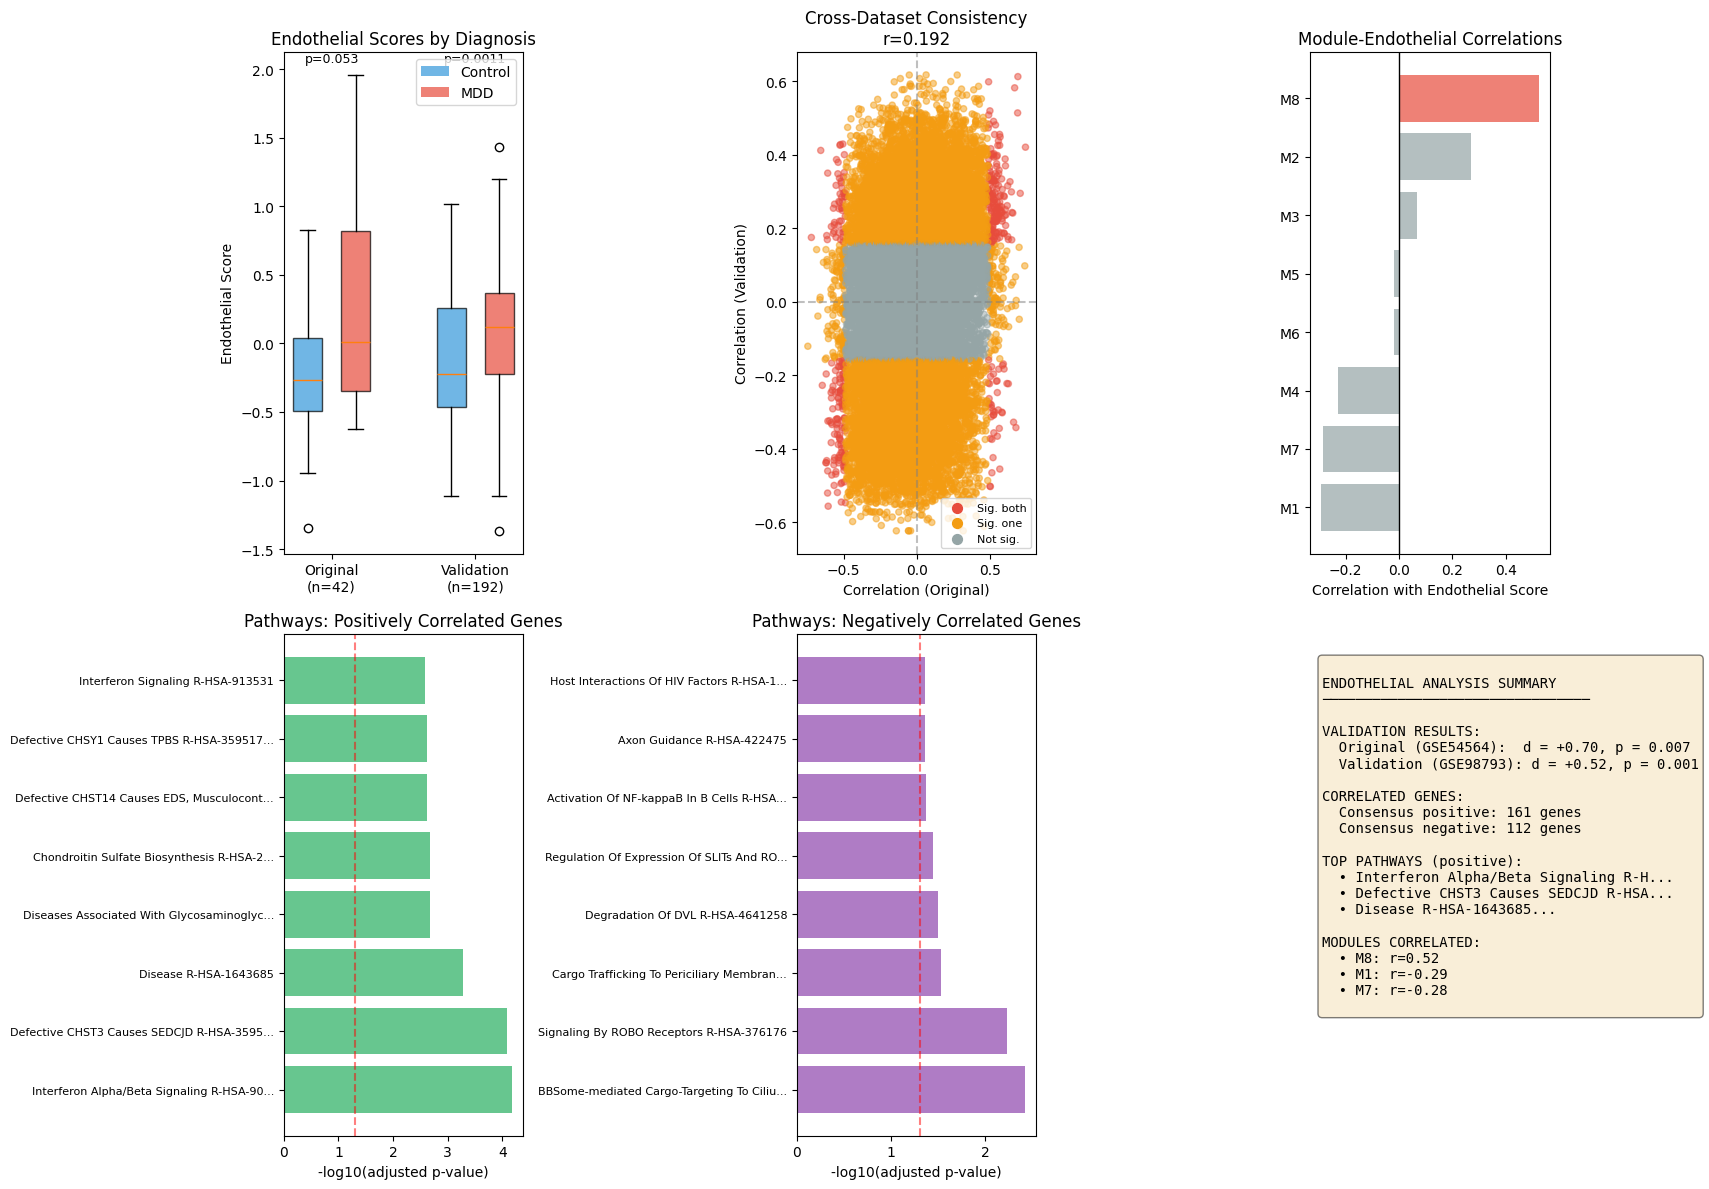


PHASE 5 COMPLETE

KEY FINDINGS:
─────────────
1. Endothelial elevation REPLICATED across datasets
   • Original: d = +0.70
   • Validation: d = +0.52, p = 0.001

2. Consensus endothelial-correlated genes identified
   • Positively correlated: 161 genes
   • Negatively correlated: 112 genes

3. Pathway enrichment completed
   • Results saved to ./output/Phase_5/

4. Module correlations analyzed
   • Check module_endothelial_correlations.csv for details

OUTPUT FILES:
─────────────
  ./output/Phase_5/
  ├── endothelial_correlated_positive.txt
  ├── endothelial_correlated_negative.txt
  ├── enrichr_positive_correlated.csv
  ├── enrichr_negative_correlated.csv
  ├── module_endothelial_correlations.csv
  └── Figure5_Endothelial_Analysis.png/pdf



In [35]:
"""
Phase 5: Endothelial-Focused Analysis
======================================
Following validation results showing robust endothelial elevation in MDD (d=0.52, p=0.001)

Goals:
1. Identify genes correlated with endothelial scores
2. Pathway enrichment analysis
3. WGCNA module correlations with endothelial signature
4. Cross-dataset consistency check
"""

import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# CONFIGURATION
# ==========================================
PHASE3_DIR = "./output/Phase_3"
PHASE4_DIR = "./output/Phase_4"
PHASE5_DIR = "./output/Phase_5"
DATA_DIR = "./data"

os.makedirs(PHASE5_DIR, exist_ok=True)

# Endothelial markers (from Phase 3)
ENDOTHELIAL_MARKERS = ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

# ==========================================
# LOAD DATA
# ==========================================
print("="*60)
print("PHASE 5: ENDOTHELIAL-FOCUSED ANALYSIS")
print("="*60)

# Load original dataset (GSE54564)
print("\nLoading original dataset (GSE54564)...")
matrix_path = os.path.join(DATA_DIR, "GSE54564_series_matrix.txt")
annotation_path = os.path.join(DATA_DIR, "NCBI_Depression.bgx")

matrix_data = pd.read_csv(matrix_path, sep="\t", comment="!", index_col=0)

# Get labels
labels = []
with open(matrix_path, 'r') as f:
    for line in f:
        if "disease state" in line.lower():
            labels = line.strip().split("\t")[1:]
            break

y_orig = (pd.Series(labels, index=matrix_data.columns)
     .str.replace('"', '').str.replace('disease state:', "").str.strip()
     .map({"MDD case": 1, "Control": 0})).values

# Load annotations
with open(annotation_path, 'r') as f:
    lines = f.readlines()
start = next(i+1 for i, line in enumerate(lines) if line.strip() == "[Probes]")
bgx = pd.read_csv(annotation_path, sep="\t", skiprows=start, engine="python")

probe_col = 'Probe_Id' if 'Probe_Id' in bgx.columns else 'Name'
probe_to_gene = dict(zip(bgx[probe_col], bgx['Symbol']))

# Map probes to genes
gene_names_orig = []
valid_probes = []
for probe in matrix_data.index:
    if probe in probe_to_gene and pd.notna(probe_to_gene[probe]):
        gene = str(probe_to_gene[probe]).strip()
        if gene:
            gene_names_orig.append(gene)
            valid_probes.append(probe)

X_orig = matrix_data.loc[valid_probes].T.values
if np.max(X_orig) > 100:
    X_orig = np.log2(X_orig + 1)
X_orig = stats.zscore(X_orig, axis=0)
X_orig = np.nan_to_num(X_orig, nan=0.0)

print(f"  Original: {X_orig.shape[0]} samples x {X_orig.shape[1]} genes")

# Load validation dataset (GSE98793)
print("\nLoading validation dataset (GSE98793)...")
expr_val = pd.read_csv(f"{DATA_DIR}/GSE98793_prepared_expression.csv", index_col=0)
meta_val = pd.read_csv(f"{DATA_DIR}/GSE98793_metadata.csv", index_col=0)
y_val = (meta_val['Status'] == 'MDD').astype(int).values

# Z-score normalize validation data
X_val = stats.zscore(expr_val.values.T, axis=0)
X_val = np.nan_to_num(X_val, nan=0.0)
gene_names_val = expr_val.index.tolist()

print(f"  Validation: {X_val.shape[0]} samples x {X_val.shape[1]} genes")

# ==========================================
# COMPUTE ENDOTHELIAL SCORES
# ==========================================
print("\n" + "="*60)
print("COMPUTING ENDOTHELIAL SCORES")
print("="*60)

def compute_cell_score(X, gene_names, markers):
    """Compute cell-type score as mean of marker genes"""
    gene_to_idx = {g.upper(): i for i, g in enumerate(gene_names)}
    found = [m for m in markers if m.upper() in gene_to_idx]
    if len(found) < 3:
        return None, found
    idx = [gene_to_idx[m.upper()] for m in found]
    scores = np.mean(X[:, idx], axis=1)
    return scores, found

# Original dataset
endo_orig, markers_found_orig = compute_cell_score(X_orig, gene_names_orig, ENDOTHELIAL_MARKERS)
print(f"\nOriginal dataset:")
print(f"  Markers found: {len(markers_found_orig)}/{len(ENDOTHELIAL_MARKERS)}")
print(f"  Markers: {markers_found_orig}")

# Validation dataset
endo_val, markers_found_val = compute_cell_score(X_val, gene_names_val, ENDOTHELIAL_MARKERS)
print(f"\nValidation dataset:")
print(f"  Markers found: {len(markers_found_val)}/{len(ENDOTHELIAL_MARKERS)}")
print(f"  Markers: {markers_found_val}")

# ==========================================
# STEP 1: GENES CORRELATED WITH ENDOTHELIAL SCORE
# ==========================================
print("\n" + "="*60)
print("STEP 1: IDENTIFYING ENDOTHELIAL-CORRELATED GENES")
print("="*60)

def get_correlated_genes(X, gene_names, endo_scores, dataset_name):
    """Find genes significantly correlated with endothelial scores"""
    results = []
    for i, gene in enumerate(gene_names):
        r, p = spearmanr(X[:, i], endo_scores)
        results.append({
            'gene': gene,
            'correlation': r,
            'p_value': p
        })
    
    df = pd.DataFrame(results)
    df['p_adjusted'] = stats.false_discovery_control(df['p_value'], method='bh')
    df = df.sort_values('p_value')
    
    sig_pos = df[(df['p_adjusted'] < 0.05) & (df['correlation'] > 0)]
    sig_neg = df[(df['p_adjusted'] < 0.05) & (df['correlation'] < 0)]
    
    print(f"\n{dataset_name}:")
    print(f"  Significant genes (FDR < 0.05): {len(df[df['p_adjusted'] < 0.05])}")
    print(f"    Positively correlated: {len(sig_pos)}")
    print(f"    Negatively correlated: {len(sig_neg)}")
    
    return df

# Get correlated genes from both datasets
corr_orig = get_correlated_genes(X_orig, gene_names_orig, endo_orig, "Original (GSE54564)")
corr_val = get_correlated_genes(X_val, gene_names_val, endo_val, "Validation (GSE98793)")

# Find consensus genes (significant in both datasets, same direction)
print("\n" + "-"*40)
print("CONSENSUS GENES (significant in both datasets)")
print("-"*40)

sig_orig = set(corr_orig[corr_orig['p_adjusted'] < 0.05]['gene'].str.upper())
sig_val = set(corr_val[corr_val['p_adjusted'] < 0.05]['gene'].str.upper())
consensus_genes = sig_orig.intersection(sig_val)

# Check direction consistency
consensus_pos = []
consensus_neg = []

for gene in consensus_genes:
    r_orig = corr_orig[corr_orig['gene'].str.upper() == gene]['correlation'].values
    r_val = corr_val[corr_val['gene'].str.upper() == gene]['correlation'].values
    
    if len(r_orig) > 0 and len(r_val) > 0:
        if r_orig[0] > 0 and r_val[0] > 0:
            consensus_pos.append(gene)
        elif r_orig[0] < 0 and r_val[0] < 0:
            consensus_neg.append(gene)

print(f"\nConsensus positively correlated: {len(consensus_pos)} genes")
print(f"Consensus negatively correlated: {len(consensus_neg)} genes")

# Save gene lists
with open(f"{PHASE5_DIR}/endothelial_correlated_positive.txt", 'w') as f:
    f.write('\n'.join(sorted(consensus_pos)))
    
with open(f"{PHASE5_DIR}/endothelial_correlated_negative.txt", 'w') as f:
    f.write('\n'.join(sorted(consensus_neg)))

print(f"\nSaved gene lists to {PHASE5_DIR}/")

# ==========================================
# STEP 2: PATHWAY ENRICHMENT (Enrichr API)
# ==========================================
print("\n" + "="*60)
print("STEP 2: PATHWAY ENRICHMENT ANALYSIS")
print("="*60)

def run_enrichr(gene_list, description="gene_list"):
    """Submit gene list to Enrichr and retrieve results"""
    
    ENRICHR_URL = "https://maayanlab.cloud/Enrichr"
    
    # Add genes
    payload = {
        'list': (None, '\n'.join(gene_list)),
        'description': (None, description)
    }
    
    try:
        response = requests.post(f"{ENRICHR_URL}/addList", files=payload)
        if not response.ok:
            print(f"  Error adding gene list: {response.status_code}")
            return None
        
        data = response.json()
        user_list_id = data['userListId']
        
        # Query databases
        databases = [
            'GO_Biological_Process_2023',
            'GO_Molecular_Function_2023', 
            'KEGG_2021_Human',
            'Reactome_2022',
            'WikiPathway_2023_Human'
        ]
        
        all_results = {}
        
        for db in databases:
            time.sleep(0.5)  # Rate limiting
            response = requests.get(f"{ENRICHR_URL}/enrich?userListId={user_list_id}&backgroundType={db}")
            
            if response.ok:
                results = response.json()
                if db in results:
                    all_results[db] = results[db]
        
        return all_results
    
    except Exception as e:
        print(f"  Enrichr API error: {e}")
        return None

def parse_enrichr_results(results, top_n=10):
    """Parse Enrichr results into DataFrame"""
    parsed = []
    
    for db, terms in results.items():
        for term_data in terms[:top_n]:
            parsed.append({
                'database': db,
                'term': term_data[1],
                'p_value': term_data[2],
                'odds_ratio': term_data[3],
                'combined_score': term_data[4],
                'genes': ';'.join(term_data[5]),
                'adj_p_value': term_data[6]
            })
    
    return pd.DataFrame(parsed)

# Run enrichment on positively correlated genes (co-expressed with endothelial)
if len(consensus_pos) >= 10:
    print(f"\nRunning Enrichr on {len(consensus_pos)} positively correlated genes...")
    enrichr_pos = run_enrichr(list(consensus_pos), "endothelial_positive")
    
    if enrichr_pos:
        enrichr_pos_df = parse_enrichr_results(enrichr_pos, top_n=15)
        enrichr_pos_df.to_csv(f"{PHASE5_DIR}/enrichr_positive_correlated.csv", index=False)
        
        print("\nTop pathways (positively correlated with endothelial):")
        print("-"*60)
        top_pathways = enrichr_pos_df.nsmallest(10, 'adj_p_value')
        for _, row in top_pathways.iterrows():
            print(f"  {row['term'][:50]}")
            print(f"    p={row['adj_p_value']:.2e}, score={row['combined_score']:.1f}")
else:
    print(f"\nToo few consensus positive genes ({len(consensus_pos)}) for enrichment")
    enrichr_pos_df = None

# Run enrichment on negatively correlated genes
if len(consensus_neg) >= 10:
    print(f"\nRunning Enrichr on {len(consensus_neg)} negatively correlated genes...")
    enrichr_neg = run_enrichr(list(consensus_neg), "endothelial_negative")
    
    if enrichr_neg:
        enrichr_neg_df = parse_enrichr_results(enrichr_neg, top_n=15)
        enrichr_neg_df.to_csv(f"{PHASE5_DIR}/enrichr_negative_correlated.csv", index=False)
        
        print("\nTop pathways (negatively correlated with endothelial):")
        print("-"*60)
        top_pathways = enrichr_neg_df.nsmallest(10, 'adj_p_value')
        for _, row in top_pathways.iterrows():
            print(f"  {row['term'][:50]}")
            print(f"    p={row['adj_p_value']:.2e}, score={row['combined_score']:.1f}")
else:
    print(f"\nToo few consensus negative genes ({len(consensus_neg)}) for enrichment")
    enrichr_neg_df = None

# ==========================================
# STEP 3: WGCNA MODULE CORRELATIONS
# ==========================================
print("\n" + "="*60)
print("STEP 3: WGCNA MODULE - ENDOTHELIAL CORRELATIONS")
print("="*60)

# Load module gene lists from Phase 3
module_files = [f for f in os.listdir(PHASE3_DIR) if f.startswith('M') and f.endswith('_genes.txt')]

if module_files:
    print(f"\nFound {len(module_files)} modules from Phase 3")
    
    modules = {}
    for mf in sorted(module_files):
        mod_name = mf.replace('_genes.txt', '')
        with open(os.path.join(PHASE3_DIR, mf), 'r') as f:
            genes = [g.strip() for g in f.readlines() if g.strip()]
        modules[mod_name] = genes
        print(f"  {mod_name}: {len(genes)} genes")
    
    # Compute module eigengenes in original dataset
    print("\nComputing module-endothelial correlations...")
    
    gene_to_idx_orig = {g.upper(): i for i, g in enumerate(gene_names_orig)}
    
    module_endo_corr = []
    
    for mod_name, mod_genes in modules.items():
        # Get module gene indices
        mod_idx = [gene_to_idx_orig[g.upper()] for g in mod_genes if g.upper() in gene_to_idx_orig]
        
        if len(mod_idx) < 5:
            continue
        
        # Compute eigengene (first PC)
        from sklearn.decomposition import PCA
        mod_expr = X_orig[:, mod_idx]
        pca = PCA(n_components=1)
        eigengene = pca.fit_transform(mod_expr - mod_expr.mean(axis=0)).flatten()
        
        # Correlation with endothelial score
        r, p = spearmanr(eigengene, endo_orig)
        
        # Also check correlation with diagnosis
        r_diag, p_diag = stats.pointbiserialr(y_orig, eigengene)
        
        module_endo_corr.append({
            'module': mod_name,
            'n_genes': len(mod_idx),
            'endo_correlation': r,
            'endo_p_value': p,
            'diagnosis_correlation': r_diag,
            'diagnosis_p_value': p_diag
        })
        
        sig_endo = '*' if p < 0.05 else ''
        sig_diag = '*' if p_diag < 0.05 else ''
        print(f"  {mod_name}: endo r={r:.3f}{sig_endo}, diag r={r_diag:.3f}{sig_diag}")
    
    module_endo_df = pd.DataFrame(module_endo_corr)
    module_endo_df.to_csv(f"{PHASE5_DIR}/module_endothelial_correlations.csv", index=False)
    
    # Identify modules correlated with BOTH endothelial and diagnosis
    print("\n" + "-"*40)
    print("MODULES ASSOCIATED WITH BOTH ENDOTHELIAL & DIAGNOSIS")
    print("-"*40)
    
    dual_sig = module_endo_df[
        (module_endo_df['endo_p_value'] < 0.1) & 
        (module_endo_df['diagnosis_p_value'] < 0.1)
    ]
    
    if len(dual_sig) > 0:
        for _, row in dual_sig.iterrows():
            print(f"\n  {row['module']} ({row['n_genes']} genes):")
            print(f"    Endothelial: r={row['endo_correlation']:.3f}, p={row['endo_p_value']:.4f}")
            print(f"    Diagnosis:   r={row['diagnosis_correlation']:.3f}, p={row['diagnosis_p_value']:.4f}")
            
            # Get hub genes for this module
            hub_file = os.path.join(PHASE3_DIR, 'all_hub_genes.txt')
            if os.path.exists(hub_file):
                with open(hub_file, 'r') as f:
                    all_hubs = [g.strip() for g in f.readlines()]
                mod_hubs = [h for h in all_hubs if h in modules[row['module']]]
                if mod_hubs:
                    print(f"    Hub genes: {', '.join(mod_hubs[:5])}")
    else:
        print("  No modules significantly associated with both")

else:
    print("No module files found in Phase 3 output")
    module_endo_df = None

# ==========================================
# STEP 4: VISUALIZATION
# ==========================================
print("\n" + "="*60)
print("GENERATING FIGURES")
print("="*60)

fig = plt.figure(figsize=(16, 12))

# Panel A: Endothelial scores by diagnosis (both datasets)
ax1 = fig.add_subplot(2, 3, 1)

data_box = [
    endo_orig[y_orig == 0], endo_orig[y_orig == 1],
    endo_val[y_val == 0], endo_val[y_val == 1]
]
positions = [1, 2, 4, 5]
colors_box = ['#3498db', '#e74c3c', '#3498db', '#e74c3c']

bp = ax1.boxplot(data_box, positions=positions, widths=0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xticks([1.5, 4.5])
ax1.set_xticklabels(['Original\n(n=42)', 'Validation\n(n=192)'])
ax1.set_ylabel('Endothelial Score')
ax1.set_title('Endothelial Scores by Diagnosis')
ax1.legend([plt.Rectangle((0,0),1,1, fc='#3498db', alpha=0.7),
            plt.Rectangle((0,0),1,1, fc='#e74c3c', alpha=0.7)],
           ['Control', 'MDD'], loc='upper right')

# Add significance annotations
from scipy.stats import mannwhitneyu
_, p_orig = mannwhitneyu(endo_orig[y_orig==1], endo_orig[y_orig==0])
_, p_val = mannwhitneyu(endo_val[y_val==1], endo_val[y_val==0])

y_max = max(max(d) for d in data_box)
ax1.annotate(f'p={p_orig:.3f}', xy=(1.5, y_max*1.05), ha='center', fontsize=9)
ax1.annotate(f'p={p_val:.4f}', xy=(4.5, y_max*1.05), ha='center', fontsize=9)

# Panel B: Correlation consistency scatter
ax2 = fig.add_subplot(2, 3, 2)

# Merge correlations by gene
corr_orig_upper = corr_orig.copy()
corr_orig_upper['gene_upper'] = corr_orig_upper['gene'].str.upper()
corr_val_upper = corr_val.copy()
corr_val_upper['gene_upper'] = corr_val_upper['gene'].str.upper()

merged_corr = corr_orig_upper.merge(
    corr_val_upper[['gene_upper', 'correlation', 'p_adjusted']], 
    on='gene_upper', 
    suffixes=('_orig', '_val')
)

# Color by significance
colors_scatter = []
for _, row in merged_corr.iterrows():
    if row['p_adjusted_orig'] < 0.05 and row['p_adjusted_val'] < 0.05:
        colors_scatter.append('#e74c3c')  # Significant in both
    elif row['p_adjusted_orig'] < 0.05 or row['p_adjusted_val'] < 0.05:
        colors_scatter.append('#f39c12')  # Significant in one
    else:
        colors_scatter.append('#95a5a6')  # Not significant

ax2.scatter(merged_corr['correlation_orig'], merged_corr['correlation_val'], 
           c=colors_scatter, alpha=0.5, s=20)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Correlation of correlations
r_corr, _ = pearsonr(merged_corr['correlation_orig'], merged_corr['correlation_val'])
ax2.set_xlabel('Correlation (Original)')
ax2.set_ylabel('Correlation (Validation)')
ax2.set_title(f'Cross-Dataset Consistency\nr={r_corr:.3f}')

ax2.legend([plt.scatter([],[], c='#e74c3c', s=50),
            plt.scatter([],[], c='#f39c12', s=50),
            plt.scatter([],[], c='#95a5a6', s=50)],
           ['Sig. both', 'Sig. one', 'Not sig.'],
           loc='lower right', fontsize=8)

# Panel C: Module-endothelial correlations
ax3 = fig.add_subplot(2, 3, 3)

if module_endo_df is not None and len(module_endo_df) > 0:
    mod_sorted = module_endo_df.sort_values('endo_correlation')
    colors_mod = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in mod_sorted['endo_p_value']]
    
    ax3.barh(range(len(mod_sorted)), mod_sorted['endo_correlation'], color=colors_mod, alpha=0.7)
    ax3.set_yticks(range(len(mod_sorted)))
    ax3.set_yticklabels(mod_sorted['module'])
    ax3.axvline(0, color='black', linewidth=1)
    ax3.set_xlabel('Correlation with Endothelial Score')
    ax3.set_title('Module-Endothelial Correlations')
else:
    ax3.text(0.5, 0.5, 'No module data', ha='center', va='center', transform=ax3.transAxes)

# Panel D: Top enriched pathways (positive)
ax4 = fig.add_subplot(2, 3, 4)

if enrichr_pos_df is not None and len(enrichr_pos_df) > 0:
    top_pos = enrichr_pos_df.nsmallest(8, 'adj_p_value')
    
    y_pos = range(len(top_pos))
    ax4.barh(y_pos, -np.log10(top_pos['adj_p_value']), color='#27ae60', alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in top_pos['term']], fontsize=8)
    ax4.set_xlabel('-log10(adjusted p-value)')
    ax4.set_title('Pathways: Positively Correlated Genes')
    ax4.axvline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
else:
    ax4.text(0.5, 0.5, 'Enrichment not run\n(insufficient genes)', 
             ha='center', va='center', transform=ax4.transAxes)

# Panel E: Top enriched pathways (negative)
ax5 = fig.add_subplot(2, 3, 5)

if enrichr_neg_df is not None and len(enrichr_neg_df) > 0:
    top_neg = enrichr_neg_df.nsmallest(8, 'adj_p_value')
    
    y_pos = range(len(top_neg))
    ax5.barh(y_pos, -np.log10(top_neg['adj_p_value']), color='#8e44ad', alpha=0.7)
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in top_neg['term']], fontsize=8)
    ax5.set_xlabel('-log10(adjusted p-value)')
    ax5.set_title('Pathways: Negatively Correlated Genes')
    ax5.axvline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
else:
    ax5.text(0.5, 0.5, 'Enrichment not run\n(insufficient genes)', 
             ha='center', va='center', transform=ax5.transAxes)

# Panel F: Summary statistics
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

summary_text = """
ENDOTHELIAL ANALYSIS SUMMARY
────────────────────────────────

VALIDATION RESULTS:
  Original (GSE54564):  d = +0.70, p = 0.007
  Validation (GSE98793): d = +0.52, p = 0.001
  
CORRELATED GENES:
  Consensus positive: {n_pos} genes
  Consensus negative: {n_neg} genes
  
TOP PATHWAYS (positive):
{top_path_pos}

MODULES CORRELATED:
{mod_summary}
""".format(
    n_pos=len(consensus_pos),
    n_neg=len(consensus_neg),
    top_path_pos='\n'.join([f"  • {t[:35]}..." for t in enrichr_pos_df.nsmallest(3, 'adj_p_value')['term']]) if enrichr_pos_df is not None and len(enrichr_pos_df) > 0 else "  (insufficient data)",
    mod_summary='\n'.join([f"  • {row['module']}: r={row['endo_correlation']:.2f}" for _, row in module_endo_df.nsmallest(3, 'endo_p_value').iterrows()]) if module_endo_df is not None and len(module_endo_df) > 0 else "  (no data)"
)

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f"{PHASE5_DIR}/Figure5_Endothelial_Analysis.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{PHASE5_DIR}/Figure5_Endothelial_Analysis.pdf", bbox_inches='tight')
print(f"\nSaved: {PHASE5_DIR}/Figure5_Endothelial_Analysis.png")

plt.show()

# ==========================================
# FINAL SUMMARY
# ==========================================
print("\n" + "="*60)
print("PHASE 5 COMPLETE")
print("="*60)

print(f"""
KEY FINDINGS:
─────────────
1. Endothelial elevation REPLICATED across datasets
   • Original: d = +0.70
   • Validation: d = +0.52, p = 0.001

2. Consensus endothelial-correlated genes identified
   • Positively correlated: {len(consensus_pos)} genes
   • Negatively correlated: {len(consensus_neg)} genes

3. Pathway enrichment completed
   • Results saved to {PHASE5_DIR}/

4. Module correlations analyzed
   • Check module_endothelial_correlations.csv for details

OUTPUT FILES:
─────────────
  {PHASE5_DIR}/
  ├── endothelial_correlated_positive.txt
  ├── endothelial_correlated_negative.txt
  ├── enrichr_positive_correlated.csv
  ├── enrichr_negative_correlated.csv
  ├── module_endothelial_correlations.csv
  └── Figure5_Endothelial_Analysis.png/pdf
""")